# Caverns with constraints

In [1]:
import glob
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import xarray as xr
from geocube.api.core import make_geocube
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

CRS = 23029

## Halite data

In [3]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

In [4]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset

    Parameters
    ----------
    dat_path : path to the .dat files
    dat_crs : CRS
    """

    gdf = {}
    # for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
    for dat_file in [
        x for x in glob.glob(
            os.path.join(dat_path, "*.dat")
        ) if "Zone" not in x
    ]:

        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[-1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[-1][:-4]]["data"] = (
            os.path.split(dat_file)[-1][:-4]
        )

    # find data resolution
    gdf_xr = gdf[list(gdf.keys())[0]].set_index(["X", "Y"]).to_xarray()
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["geometry"] = gpd.points_from_xy(gdf.X, gdf.Y, crs=dat_crs)
    gdf = gpd.GeoDataFrame(gdf)
    gdf.drop(columns=["X", "Y"], inplace=True)

    # convert to Xarray dataset
    xds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # split variables and halite members
    xds_ = {}
    for d in xds["data"].values:
        halite_member = d.split(" ")[0]
        if halite_member == "Presall":
            halite_member = "Preesall"
        unit = d.split(" ")[-1]
        zvar = d.split("Halite ")[-1].split(" XYZ")[0]
        xds_[d] = xds.sel(data=d).assign_coords(
            halite=halite_member
        ).expand_dims(dim="halite").drop_vars("data")
        xds_[d] = xds_[d].rename({"Z": zvar.replace(" ", "")})
        xds_[d][zvar.replace(" ", "")] = (
            xds_[d][zvar.replace(" ", "")].assign_attrs(
                units=unit, long_name=zvar
            )
        )

    xds = xr.combine_by_coords(xds_.values(), combine_attrs="override")

    # create extent polygon
    dat_extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    dat_extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (dat_extent[" X"][0], dat_extent[" Y"][0]),
            (dat_extent[" X"][1], dat_extent[" Y"][1]),
            (dat_extent[" X"][2], dat_extent[" Y"][2]),
            (dat_extent[" X"][3], dat_extent[" Y"][3])
        ]),
        crs=dat_crs
    )

    return xds, dat_extent

In [5]:
ds, extent = read_dat_file(DATA_DIR, CRS)

In [6]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Zones of interest

In [7]:
def zones_of_interest(
    dat_xr, dat_extent, dat_crs, min_thickness, min_depth, max_depth
):
    """
    Generate a (multi)polygon of the zones of interest by applying thickness
    and depth constraints.

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    min_thickness : minimum halite thickness [m]
    min_depth : minimum halite top depth [m]
    max_depth : maximum halite top depth [m]

    Returns
    -------
    - A (multi)polygon geodataframe of the zones of interest
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    zdf = dat_xr.where(
        (
            (dat_xr.Thickness >= min_thickness)
            & (dat_xr.TopDepth >= min_depth)
            & (dat_xr.TopDepth <= max_depth)
        ),
        drop=True
    )

    # zones of interest polygon
    zdf = zdf.max(
        dim="halite"
    )["Thickness"].to_dataframe().dropna().reset_index()
    zdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(
            gpd.points_from_xy(zdf.x, zdf.y)
        ).buffer(100).envelope,
        crs=dat_crs
    ).dissolve()

    return zdf

In [8]:
# recommendations from the Hystories project
# salt thickness >= 300 m, top depth >= 1000 m and <= 1500 m
zones = zones_of_interest(ds, extent, CRS, 300, 1000, 1500)

## Generate caverns in a regular hexagonal grid configuration

In [9]:
def generate_caverns_williams_etal(
    dat_extent, dat_crs, zones_df, diameter, separation
):
    """
    Generate caverns in a regular hexagonal grid as proposed by Williams
    et al. (2022): https://doi.org/10.1016/j.est.2022.105109.
    Hexagonal gridding method based on
    https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html.

    Parameters
    ----------
    dat_extent : extent of the data
    dat_crs : CRS
    zones_df : zones of interest
    diameter : diameter of the cavern [m]
    separation : cavern separation distance [m]

    Returns
    -------
    - A polygon geodataframe of potential caverns
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    a = np.sin(np.pi / 3)
    cols = np.arange(np.floor(xmin_), np.ceil(xmax_), 3 * separation)
    rows = np.arange(np.floor(ymin_) / a, np.ceil(ymax_) / a, separation)

    hexagons = []
    cavern_df = []
    for x in cols:
        for i, y in enumerate(rows):
            if (i % 2 == 0):
                x0 = x
            else:
                x0 = x + 1.5 * separation

            # hexagon vertices
            cavern_df.append(shapely.geometry.Point(x0, y * a))
            cavern_df.append(shapely.geometry.Point(x0 + separation, y * a))
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + (1.5 * separation), (y + separation) * a
                    )
                )
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + separation, (y + (2 * separation)) * a
                )
            )
            cavern_df.append(
                shapely.geometry.Point(x0, (y + (2 * separation)) * a)
            )
            cavern_df.append(
                shapely.geometry.Point(
                    x0 - (0.5 * separation), (y + separation) * a
                )
            )
            # hexagon centroid
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + (0.5 * separation), (y + separation) * a
                )
            )

    # generate caverns using hexagon vertices and centroids
    cavern_df = gpd.GeoDataFrame(
        geometry=gpd.GeoDataFrame(
            geometry=cavern_df, crs=dat_crs
        ).drop_duplicates().buffer(diameter / 2)
    )

    # clip caverns to the zones of interest
    cavern_df = gpd.sjoin(cavern_df, zones_df, predicate="within")

    print("Number of potential caverns:", len(cavern_df))

    return cavern_df

In [10]:
# max 80 m diameter based on Hystories
# separation distance of 4 times the diameter as recommended by Caglayan et al.
caverns = generate_caverns_williams_etal(extent, CRS, zones, 80, 80 * 4)

Number of potential caverns: 409


## Constraints

### Exploration wells

In [11]:
DATA_DIR = os.path.join("data", "exploration-wells-irish-offshore")
FILE_NAME = "Exploration_Wells_Irish_Offshore.shapezip.zip"
DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

wells = gpd.read_file(
    os.path.join(f"zip://{DATA_FILE}!{FILE_NAME[:-4]}/{FILE_NAME[:-13]}.shp")
)

wells = wells[wells["AREA"].str.contains("Kish")]

# 500 m buffer
wells = gpd.GeoDataFrame(geometry=wells.to_crs(CRS).buffer(500))

In [12]:
caverns = caverns.overlay(wells, how="difference")

### Wind farms

In [13]:
DATA_DIR = os.path.join("data", "wind-farms-foreshore-process")
FILE_NAME = "wind-farms-foreshore-process.zip"
DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

wind_farms = gpd.read_file(
    os.path.join(f"zip://{DATA_FILE}!Energy_Offshore_Renewable.shp")
)

In [14]:
# wind farms near Kish Basin
wind_farms = wind_farms.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index().sort_values("Name")

In [15]:
caverns = caverns.overlay(wind_farms, how="difference")

## Plot

In [18]:
def plot_map(dat_xr, dat_extent, dat_crs, cavern_df, var, stat):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    cavern_df : cavern distribution
    var : variable
    stat : statistic (max / min / mean)
    """

    # estimates
    print("Number of potential caverns:", len(cavern_df))
    print(f"Total volume: {len(cavern_df) * 5e5:.2E} m\N{SUPERSCRIPT THREE}")
    print(f"Storage capacity: {len(cavern_df) * 105.074 / 1e3:.2f} TWh")

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.epsg(dat_crs))

    cbar_label = (
        f"{dat_xr[var].attrs['long_name']} [{dat_xr[var].attrs['units']}]"
    )

    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        cbar_label = f"Maximum {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        cbar_label = f"Minimum {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        cbar_label = f"Mean {cbar_label}"

    plot_data[var].plot.contourf(
        cmap="jet", alpha=.65, robust=True, levels=15,
        cbar_kwargs={"label": cbar_label}
    )
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_ - 4000, ymax_ + 4000)

    cavern_df.centroid.plot(
        ax=ax, markersize=7, color="black", edgecolor="none"
    )

    wells.boundary.plot(ax=ax, color="black")

    colours = ["firebrick", "forestgreen", "black", "royalblue"]
    for index, colour in zip(range(len(wind_farms)), colours):
        wind_farms.iloc[[index]].plot(
            ax=ax, hatch="///", facecolor="none", edgecolor=colour, linewidth=1
        )

    legend_handles = [
        mpatches.Patch(
            facecolor="none", hatch="////", edgecolor=colours[x],
            label=list(wind_farms["Name"])[x]
        ) for x in range(len(wind_farms))
    ]
    legend_handles.append(
        Line2D(
            [0], [0], marker="o", markersize=10, linewidth=0,
            markeredgecolor="black", markerfacecolor="none",
            label="Exploration well"
        )
    )
    legend_handles.append(
        Line2D(
            [0], [0], marker=".", markersize=7, linewidth=0,
            markeredgecolor="none", markerfacecolor="black",
            label="Cavern"
        )
    )

    cx.add_basemap(ax, crs=dat_crs, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=.25, color="darkslategrey"
    )
    ax.add_artist(
        ScaleBar(
            1, box_alpha=0, location="lower right", color="darkslategrey"
        )
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)
    plt.tight_layout()
    plt.show()

Number of potential caverns: 399
Total volume: 2.00E+08 m³
Storage capacity: 41.92 TWh


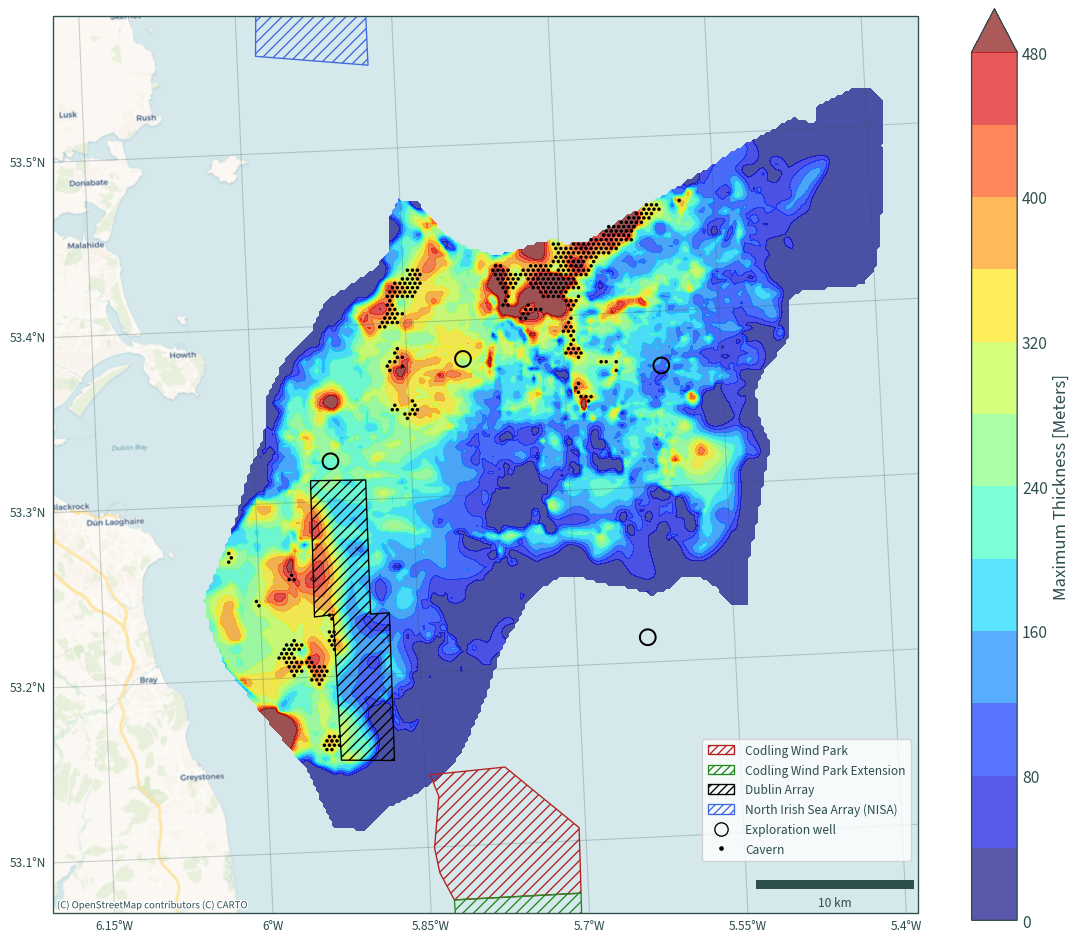

In [19]:
plot_map(ds, extent, CRS, caverns, "Thickness", "max")